In [1]:
# Python 3.9 required
# Use GPU to speed up embedding matrix calculation. Alternative: download the embedding matrix 
# already calculated by me from 
# https://drive.google.com/file/d/1vcX7GuLn9hP9SKvQRpeP8WmWiWMPBmYW/view?usp=sharing and place it 
# at the same directory level as this notebook.
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 6.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 2.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Tuple, List, Literal
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

/home/desposito/Entrevistas/hbs-assignment/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#clone the git repo that contains the data and additional information about the dataset
!git clone https://github.com/wayfair/WANDS.git

fatal: destination path 'WANDS' already exists and is not an empty directory.


In [4]:
#define functions for product search using Tf-IDF
def calculate_tfidf(dataframe):
    """
    Calculate the TF-IDF for combined product name and description.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with product_id, and other product information.

    Returns:
    TfidfVectorizer, csr_matrix: TF-IDF vectorizer and TF-IDF matrix.
    """
    # Combine product name and description to vectorize
    # NOTE: Please feel free to use any combination of columns available, some columns may contain NULL values
    combined_text = dataframe['product_name'] + ' ' + dataframe['product_description']
    vectorizer = TfidfVectorizer()
    # convert combined_text to list of unicode strings
    tfidf_matrix = vectorizer.fit_transform(combined_text.values.astype('U'))
    return vectorizer, tfidf_matrix

def get_top_products(vectorizer, tfidf_matrix, query, top_n=10):
    """
    Get top N products for a given query based on TF-IDF similarity.

    Parameters:
    vectorizer (TfidfVectorizer): Trained TF-IDF vectorizer.
    tfidf_matrix (csr_matrix): TF-IDF matrix for the products.
    query (str): Search query.
    top_n (int): Number of top products to return.

    Returns:
    list: List of top N product IDs.
    """
    query_vector = vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_product_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return top_product_indices

In [5]:
#define functions for evaluating retrieval performance
def map_at_k(true_ids, predicted_ids, k=10):
    """
    Calculate the Mean Average Precision at K (MAP@K).

    Parameters:
    true_ids (list): List of relevant product IDs.
    predicted_ids (list): List of predicted product IDs.
    k (int): Number of top elements to consider.
             NOTE: IF you wish to change top k, please provide a justification for choosing the new value

    Returns:
    float: MAP@K score.
    """
    #if either list is empty, return 0
    if not len(true_ids) or not len(predicted_ids):
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, p_id in enumerate(predicted_ids[:k]):
        if p_id in true_ids and p_id not in predicted_ids[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(true_ids), k)

In [6]:
# Please add any new evaluation functions here
def weighted_map_at_k(
        exact_match_ids: List[int], partial_match_ids: List[int], retrieval_ids: List[int], 
        k: int = 10
) -> float:
    """
    Calculate the Weighted Mean Average Precision at K (Weighted MAP@K).

    Parameters:
    exact_match_ids (list): List of IDs of exact matches.
    partial_match_ids (list): List of IDs of partial matches.
    retrieval_ids (list): List of retrieved IDs, ordered by rank.
    k (int): Number of top elements to consider.

    Returns:
    float: Weighted MAP@K score.
    """
    if not retrieval_ids:
        return 0.0

    score = 0.0
    weighted_num_hits = 0.0
    exact_match_weight = 1.0
    partial_match_weight = 0.5

    seen_ids = set()

    for i, retrieved_id in enumerate(retrieval_ids[:k]):
        weight = 0.0
        if retrieved_id in exact_match_ids:
            weight = exact_match_weight
        elif retrieved_id in partial_match_ids:
            weight = partial_match_weight

        if weight > 0 and retrieved_id not in seen_ids:
            weighted_num_hits += weight
            score += weighted_num_hits / (i + 1.0)
            seen_ids.add(retrieved_id)

    num_exact_relevant = len(set(exact_match_ids))
    num_partial_relevant = len(set(partial_match_ids) - set(exact_match_ids))
    total_relevant_weight = (
        num_exact_relevant * exact_match_weight + num_partial_relevant * partial_match_weight
    )

    if total_relevant_weight == 0:
        return 0.0
    else:
        return score / min(total_relevant_weight, k)

In [7]:
# get search queries
query_df = pd.read_csv("WANDS/dataset/query.csv", sep='\t')

In [8]:
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [9]:
# get products
product_df = pd.read_csv("WANDS/dataset/product.csv", sep='\t')

In [10]:
display(product_df.head())
display(product_df['product_name'].apply(len).max())
display(product_df['product_description'].apply(lambda x: len(x) if isinstance(x, str) else 0).max())

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [12]:
# get manually labeled groundtruth lables
label_df = pd.read_csv("WANDS/dataset/label.csv", sep='\t')

In [13]:
display(label_df.head())
display(label_df['label'].unique())

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


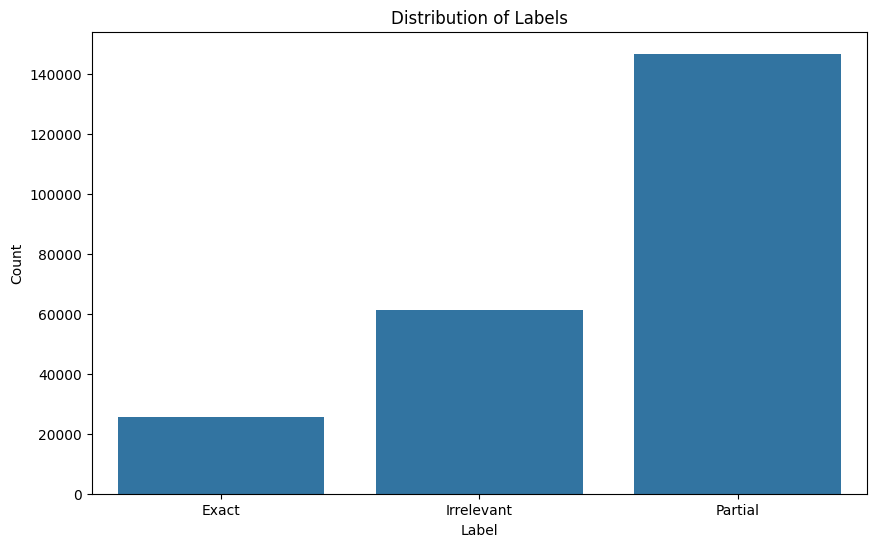

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=label_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [16]:
label_counts = label_df['label'].value_counts()
size = label_df.shape[0]
display(f"Exact {label_counts['Exact']/size}")
display(f"Partial {label_counts['Partial']/size}")
display(f"Irrelevant {label_counts['Irrelevant']/size}")

'Exact 0.10972036599156985'

'Partial 0.6281184674959734'

'Irrelevant 0.26216116651245674'

In [19]:
#group the labels for each query to use when identifying exact matches
grouped_label_df = label_df.groupby('query_id')

In [20]:
# Calculate TF-IDF
vectorizer, tfidf_matrix = calculate_tfidf(product_df)
display(len(vectorizer.vocabulary_))
display(tfidf_matrix.shape)

44307

(42994, 44307)

In [21]:
#Sanity check code block to see if the search results are relevant
#implementing a function to retrieve top K product IDs for a query
def get_top_product_ids_for_query(query):
    top_product_indices = get_top_products(vectorizer, tfidf_matrix, query, top_n=10)
    top_product_ids = product_df.iloc[top_product_indices]['product_id'].tolist()
    return top_product_ids

#define the test query
query = "armchair"

#obtain top product IDs
top_product_ids = get_top_product_ids_for_query(query)

print(f"Top products for '{query}':")
for product_id in top_product_ids:
    product = product_df.loc[product_df['product_id'] == product_id]
    print(product_id, product['product_name'].values[0])

Top products for 'armchair':
12756 24.41 '' wide tufted polyester armchair
42698 donham armchair
42697 donham 25 '' wide armchair
41270 almaraz 33.7 '' wide leather match armchair
23907 faizah 27.6 '' wide tufted polyester armchair
31564 biloxi 34.75 '' wide armchair
41306 hartsell 33 '' wide armchair
1527 howington 39 '' wide tufted linen armchair
42802 donham polyester lounge chair
6532 ogan 29 '' wide polyester armchair


In [22]:
#implementing a function to retrieve exact match product IDs for a query_id
def get_matches_for_query(query_id: str, label: Literal['Exact', 'Irrelevant', 'Partial']) -> List[int]:
    query_group = grouped_label_df.get_group(query_id)
    exact_matches = query_group.loc[query_group['label'] == label]['product_id'].values
    return exact_matches

#applying the function to obtain top product IDs and adding top K product IDs to the dataframe 
query_df['top_product_ids'] = query_df['query'].apply(get_top_product_ids_for_query)

#adding the list of exact match product_IDs from labels_df
query_df['exact_match_ids'] = query_df['query_id'].apply(lambda x: get_matches_for_query(x, 'Exact'))
query_df['partial_match_ids'] = query_df['query_id'].apply(lambda x: get_matches_for_query(x, 'Partial'))

#assign the map@k score
query_df['map@k'] = query_df.apply(
    lambda x: map_at_k(x['exact_match_ids'], x['top_product_ids'], k=10), axis=1
)

#assign the weighted_map@k score
query_df['weighted_map@k'] = query_df.apply(
    lambda x: weighted_map_at_k(
        x['exact_match_ids'], x['partial_match_ids'], x['top_product_ids'], k=10,
    ), axis=1
)


In [23]:
# calculate the MAP and Weighted MAP across the entire query set
display(query_df.loc[:, 'map@k'].mean())
display(query_df.loc[:, 'weighted_map@k'].mean())

np.float64(0.29319624944885364)

In [28]:
def calculate_embedding_matrix(dataframe: pd.DataFrame) -> Tuple[SentenceTransformer, np.ndarray]:
    """
    Calculate the embedding matrix for combined product name and description using SentenceTransformer.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with product information.

    Returns:
    np.ndarray: Embedding matrix.
    """
    # Combine product name and description to vectorize
    combined_text = dataframe['product_name'] + ' ' + dataframe['product_description']
    #model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
    model = SentenceTransformer('Snowflake/snowflake-arctic-embed-m-v2.0', trust_remote_code=True) # Max tokens 8192

    # Load embedding matrix if available
    if os.path.exists('embedding_matrix.npy'):
        embedding_matrix = np.load('embedding_matrix.npy')
        return model, embedding_matrix

    # Convert combined_text to list of unicode strings
    combined_text_list = combined_text.values.astype('U')

    batch_size = 16

    display(
        f"Start encoding {len(combined_text_list)} products with a batch size of {batch_size}. "
        f"There are {(len(combined_text_list)//batch_size) + 1} batches."
    )

    embedding_matrix = []
    for i in range(0, len(combined_text_list), batch_size):
        start_time = time.time()
        batch_embeddings = model.encode(
            combined_text_list[i:i + batch_size], convert_to_tensor=False
        )
        embedding_matrix.extend(batch_embeddings)
        end_time = time.time()
        display(f"Batch {i // batch_size + 1} took {end_time - start_time:.2f} seconds")
    
    # Save embedding matrix
    np.save('embedding_matrix.npy', embedding_matrix)
    return model, np.array(embedding_matrix)


In [26]:
def get_top_products_using_semantic_search(
        model: SentenceTransformer, embedding_matrix: np.ndarray, query: str, top_n: int = 10
):
    query_vector = model.encode(
        [query], prompt_name="query", convert_to_tensor=False
    )[0]

    # Reshape query_vector to a 2D array
    query_vector = query_vector.reshape(1, -1)

    cosine_similarities = cosine_similarity(query_vector, embedding_matrix).flatten()
    top_product_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return top_product_indices

In [29]:
embedding_model, embedding_matrix = calculate_embedding_matrix(product_df)

A new version of the following files was downloaded from https://huggingface.co/Snowflake/snowflake-arctic-embed-m-v2.0:
- configuration_hf_alibaba_nlp_gte.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/Snowflake/snowflake-arctic-embed-m-v2.0:
- modeling_hf_alibaba_nlp_gte.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


In [30]:
def get_top_product_ids_for_query_using_semantic_search(query):
    top_product_indices = get_top_products_using_semantic_search(embedding_model, embedding_matrix, query, top_n=10)
    top_product_ids = product_df.iloc[top_product_indices]['product_id'].tolist()
    return top_product_ids

query_df['semantic_search_top_product_ids'] = query_df['query'].apply(get_top_product_ids_for_query_using_semantic_search)

NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(1, 7, 12, 64) (torch.float32)
     key         : shape=(1, 7, 12, 64) (torch.float32)
     value       : shape=(1, 7, 12, 64) (torch.float32)
     attn_bias   : <class 'xformers.ops.fmha.attn_bias.BlockDiagonalMask'>
     p           : 0.0
`fa3F@v2.7.2.post1` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.bfloat16, torch.float16})
`fa2F@v2.5.7-pt` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.bfloat16, torch.float16})
`cutlassF-pt` is not supported because:
    device=cpu (supported: {'cuda'})

In [33]:
#assign the weighted_map@k score
query_df['semantic_weighted_map@k'] = query_df.apply(
    lambda x: weighted_map_at_k(
        x['exact_match_ids'], x['partial_match_ids'], x['semantic_search_top_product_ids'], k=10,
    ), axis=1
)

#assign the map@k score
query_df['semantic_map@k'] = query_df.apply(
    lambda x: map_at_k(x['exact_match_ids'], x['semantic_search_top_product_ids'], k=10), axis=1
)

In [34]:
display(query_df.loc[:, 'semantic_map@k'].mean())
display(query_df.loc[:, 'semantic_weighted_map@k'].mean())

np.float64(0.42508602246840094)

np.float64(0.5756416075244201)